In [1]:
import sys
sys.path.append('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders')


from get_data import get_data, get_data_train, get_data_val
import torch
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datasets import InMemDataLoader
import torch.nn.functional as F
import torch
import nibabel as nib     # Read / write access to some common neuroimaging file formats
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
from scipy import interpolate
import ot

import jmp_solver1.surrogates
import matplotlib
matplotlib.rcdefaults() 

In [2]:
device

device(type='cpu')

In [3]:
deg_quad = 80
u_ob = jmp_solver1.surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
x = np.linspace(-1,1,96)
X_p = u_ob.data_axes([x,x]).T

In [4]:
# Get RK coefficients for these images and also the images

In [5]:
#before executing this cell you need to have preexisting trained coefficients for what ever degree you want

trainImages = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/savedDatasetAndCoeffs/trainDataSet.pt',map_location=torch.device('cpu'))
trainCoeffs = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/savedDatasetAndCoeffs/trainDataRK_coeffs.pt',map_location=torch.device('cpu'))


testImages = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/savedDatasetAndCoeffs/testDataSet.pt',map_location=torch.device('cpu'))
testCoeffs = torch.load('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/savedDatasetAndCoeffs/testDataRK_coeffs.pt',map_location=torch.device('cpu'))

In [6]:
Analys_size = 50

In [7]:
trainImages = trainImages[:Analys_size]
trainCoeffs = trainCoeffs[:Analys_size]

testImages = testImages[:Analys_size]
testCoeffs = testCoeffs[:Analys_size]

In [8]:
trainCoeffs.shape

torch.Size([50, 6561])

In [9]:
# load trained rAE and bAE

#from models_un import AE_un
from models import AE
from activations import Sin

#path_hyb = '/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/FMNIST_RK_space/output/MRT_full/test_run_saving/'
#path_unhyb = '/home/ramana44/FashionMNIST5LayersTrials/output/MRT_full/test_run_saving/'

path_unhyb = '/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/NonHybridOasisMRI_AE-REG/output/MRT_full/test_run_saving/'
path_hyb = '/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders-STORAGE_SPACE/output/MRT_full/test_run_saving/'


#specify hyperparameters
reg_nodes_sampling = 'legendre'
alpha = 0.1
frac = 0.8
hidden_size = 1000
deg_poly = 20
deg_poly_forRK = 20
latent_dim = 50
lr = 0.0001
no_layers = 5
#no_epochs= 100
#name_hyb = '_'+reg_nodes_sampling+'_'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly_forRK)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)#+'_'+str(no_epochs)

#name_unhyb = '_'+reg_nodes_sampling+'__'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)#+'_'+str(no_epochs)
name_hyb = '_'+reg_nodes_sampling+'_'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)
name_unhyb = '_'+reg_nodes_sampling+'_'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)#+'_'+str(no_epochs)

#no_channels, dx, dy = (train_loader_alz.dataset.__getitem__(1).shape)
#inp_dim = [no_channels, dx-21, dy-21]
inp_dim_hyb = (deg_quad+1)*(deg_quad+1)

inp_dim_unhyb = [1,96,96]

RK_model_reg = AE(inp_dim_hyb, hidden_size, latent_dim, no_layers, Sin()).to(device)
RK_model_base = AE(inp_dim_hyb, hidden_size, latent_dim, no_layers, Sin()).to(device)

model_reg = AE(inp_dim_unhyb, hidden_size, latent_dim, no_layers, Sin()).to(device)
model_base = AE(inp_dim_unhyb, hidden_size, latent_dim, no_layers, Sin()).to(device)

#model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])
#model_base.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])

RK_model_reg.load_state_dict(torch.load(path_hyb+'model_reg'+name_hyb, map_location=torch.device('cpu')))
RK_model_base.load_state_dict(torch.load(path_hyb+'model_base'+name_hyb, map_location=torch.device('cpu')))

model_reg.load_state_dict(torch.load(path_unhyb+'model_reg'+name_unhyb, map_location=torch.device('cpu')))
model_base.load_state_dict(torch.load(path_unhyb+'model_base'+name_unhyb, map_location=torch.device('cpu')))
#model_reg.eval()
#model_base.eval()

<All keys matched successfully>

In [10]:
unhyb_rec_rAE_train = model_reg(trainImages).view(trainImages.shape).detach().numpy() 
unhyb_rec_bAE_train = model_base(trainImages).view(trainImages.shape).detach().numpy() 

unhyb_rec_rAE_test = model_reg(testImages).view(testImages.shape).detach().numpy() 
unhyb_rec_bAE_test = model_base(testImages).view(testImages.shape).detach().numpy() 


unhyb_rec_rAE_train = torch.tensor(unhyb_rec_rAE_train, requires_grad=False)
unhyb_rec_bAE_train = torch.tensor(unhyb_rec_bAE_train, requires_grad=False)

unhyb_rec_rAE_test = torch.tensor(unhyb_rec_rAE_test, requires_grad=False)
unhyb_rec_bAE_test = torch.tensor(unhyb_rec_bAE_test, requires_grad=False)

In [11]:
rec_rAE_train = RK_model_reg(trainCoeffs.float()).view(trainCoeffs.shape)
rec_bAE_train = RK_model_base(trainCoeffs.float()).view(trainCoeffs.shape)

rec_rAE_test = RK_model_reg(testCoeffs.float()).view(testCoeffs.shape)
rec_bAE_test = RK_model_base(testCoeffs.float()).view(testCoeffs.shape)

In [12]:
# reconstruction loss after training the model completely
loss_tre = torch.mean(((unhyb_rec_rAE_test - testImages)**2)*0.5)
loss_tre

tensor(2.1609)

In [13]:
# reconstruction loss after training the model completely
loss_tre = torch.mean(((unhyb_rec_bAE_test - testImages)**2)*0.5)
loss_tre

tensor(0.0005)

In [14]:
rec_rAE_train = torch.tensor(rec_rAE_train, requires_grad=False)
rec_bAE_train = torch.tensor(rec_bAE_train, requires_grad=False)

rec_rAE_test = torch.tensor(rec_rAE_test, requires_grad=False)
rec_bAE_test = torch.tensor(rec_bAE_test, requires_grad=False)

/tmp/ipykernel_34923/1395426734.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_rAE_train = torch.tensor(rec_rAE_train, requires_grad=False)
/tmp/ipykernel_34923/1395426734.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_bAE_train = torch.tensor(rec_bAE_train, requires_grad=False)
/tmp/ipykernel_34923/1395426734.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rec_rAE_test = torch.tensor(rec_rAE_test, requires_grad=False)
/tmp/ipykernel_34923/1395426734.py:5: UserWarning: To copy construct from a tensor, it is recommend

In [15]:
reconReg_train = torch.matmul(X_p.float(), rec_rAE_train.squeeze(1).T).T

reconBase_train = torch.matmul(X_p.float(), rec_bAE_train.squeeze(1).T).T

reconReg_test = torch.matmul(X_p.float(), rec_rAE_test.squeeze(1).T).T

reconBase_test = torch.matmul(X_p.float(), rec_bAE_test.squeeze(1).T).T

In [16]:
hybrd_reconReg_train = reconReg_train.reshape(Analys_size,1,96,96)
hybrd_reconBase_train = reconBase_train.reshape(Analys_size,1,96,96)

hybrd_reconReg_test = reconReg_test.reshape(Analys_size,1,96,96)
hybrd_reconBase_test = reconBase_test.reshape(Analys_size,1,96,96)

In [17]:
# What if I get rid of negatives in unhybridized ?
'''rec_rAE_train[np.where(rec_rAE_train < 0.0)] = 0
rec_bAE_train[np.where(rec_bAE_train < 0.0)] = 0
rec_rAE_test[np.where(rec_rAE_test < 0.0)] = 0
rec_bAE_test[np.where(rec_bAE_test < 0.0)] = 0'''
# Doesn't make sense to remove negatives from unhybrid because they are coming from sine activation function. Normalization is sufficient


# Getting rid of negatives

hybrd_reconReg_train[np.where(hybrd_reconReg_train < 0.0)] = 0
hybrd_reconBase_train[np.where(hybrd_reconBase_train < 0.0)] = 0
hybrd_reconReg_test[np.where(hybrd_reconReg_test < 0.0)] = 0
hybrd_reconBase_test[np.where(hybrd_reconBase_test < 0.0)] = 0

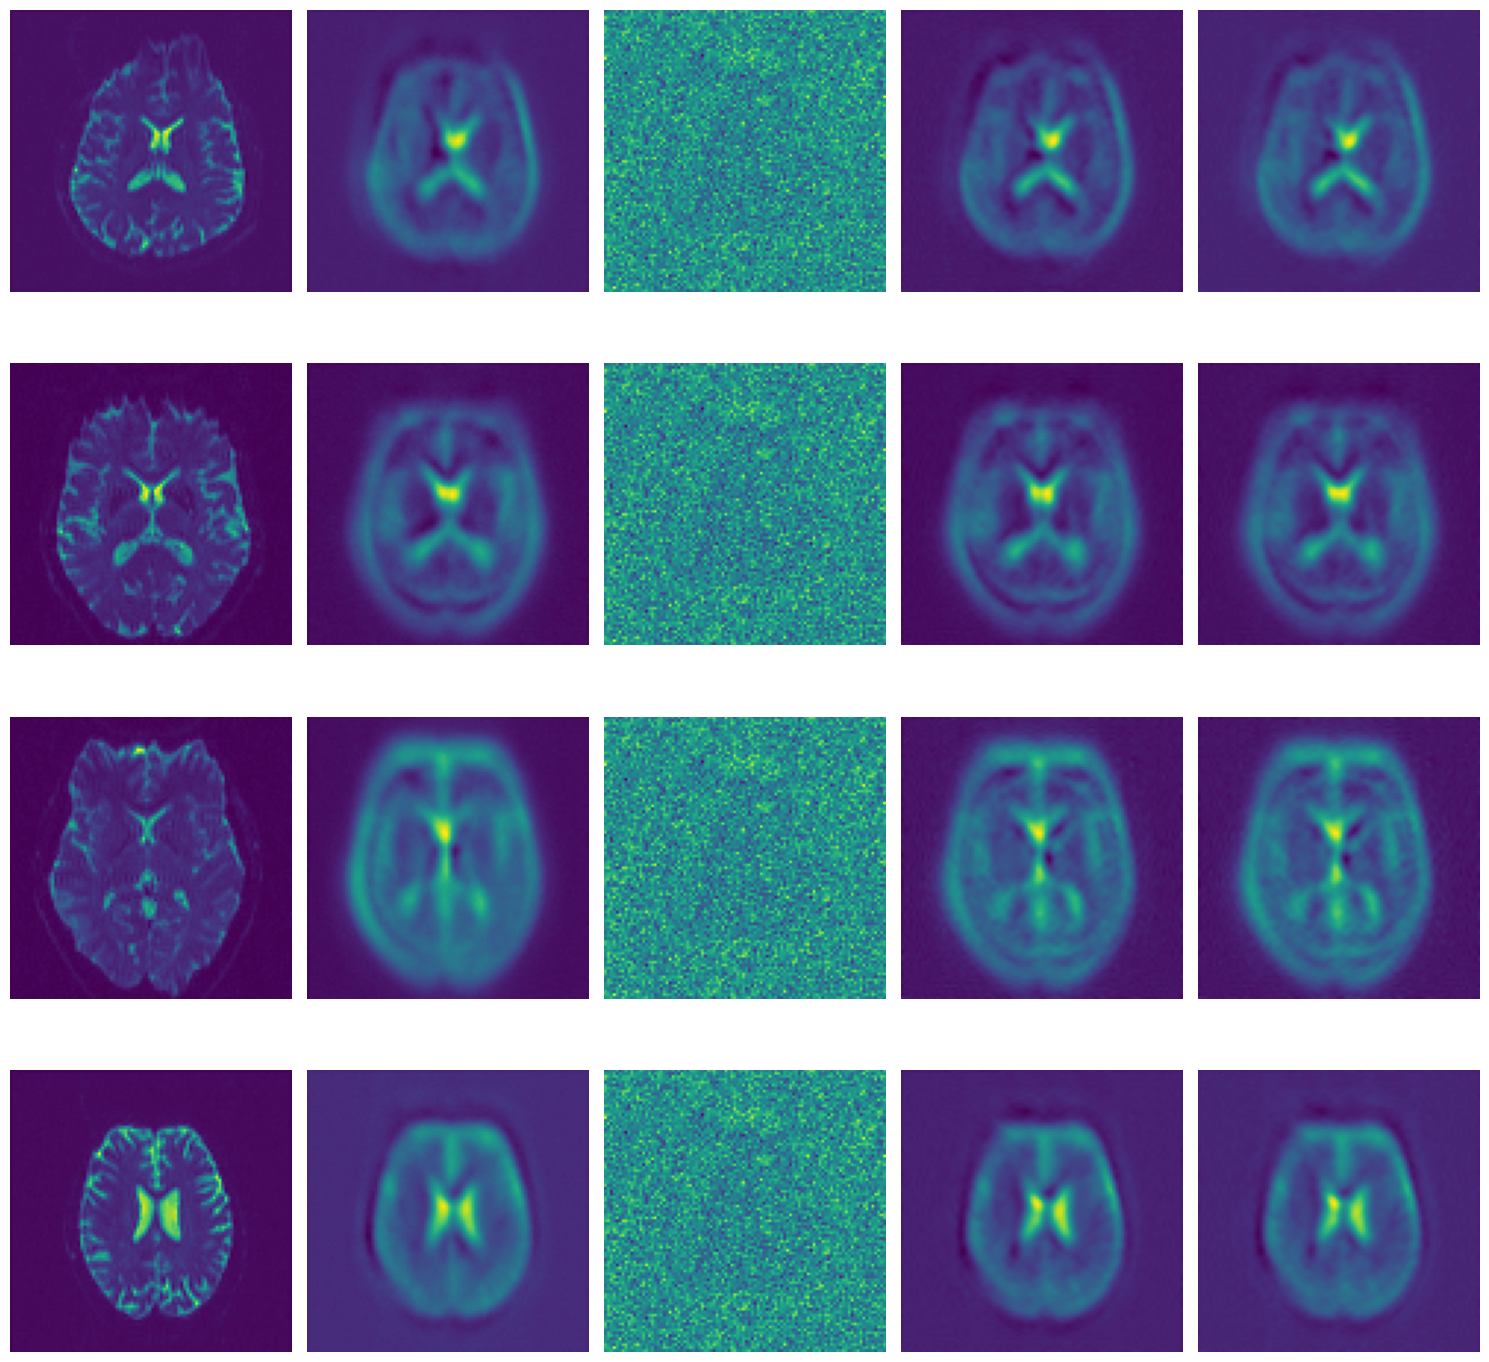

In [18]:
# PLotting trained images reconstructed

#shift = 0
tryit = 67
image_list = [3, 9, 43, 49]
rows = len(image_list)

fig, axes = plt.subplots(rows, 5, figsize=(15,15))
plt.subplots_adjust(wspace=0.1, hspace=0.01)
#for i in range(rows):
k = 0
for i in image_list:    
    
    ax1, ax2, ax3, ax4, ax5 = axes[k]
    ax1.imshow(trainImages[i][0])
    ax1.axis('off') # for removing axis
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax5.axis('off')
    #if(k==0):
        #ax1.set_title('Original', fontsize = 23)
    ax2.imshow(unhyb_rec_bAE_train[i][0])
    #if(k==0):
        #ax2.set_title('MLP-AE', fontsize = 23)
    ax3.imshow(unhyb_rec_rAE_train[i][0])
    #if(k==0):
        #ax3.set_title('AE-REG', fontsize = 23)
    ax4.imshow(hybrd_reconBase_train[i][0])
    #if(k==0):
        #ax4.set_title('Hybdrid MLP-AE', fontsize = 23)
    ax5.imshow(hybrd_reconReg_train[i][0])
    #if(k==0):
        #ax5.set_title('Hybdrid AE-REG', fontsize = 23)

    k = k+1
fig.tight_layout()
'''plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)'''
#plt.savefig('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders/Pictures_for_report/HybridTrainImagesLatDim'+str(latent_dim)+'.png')
plt.show()


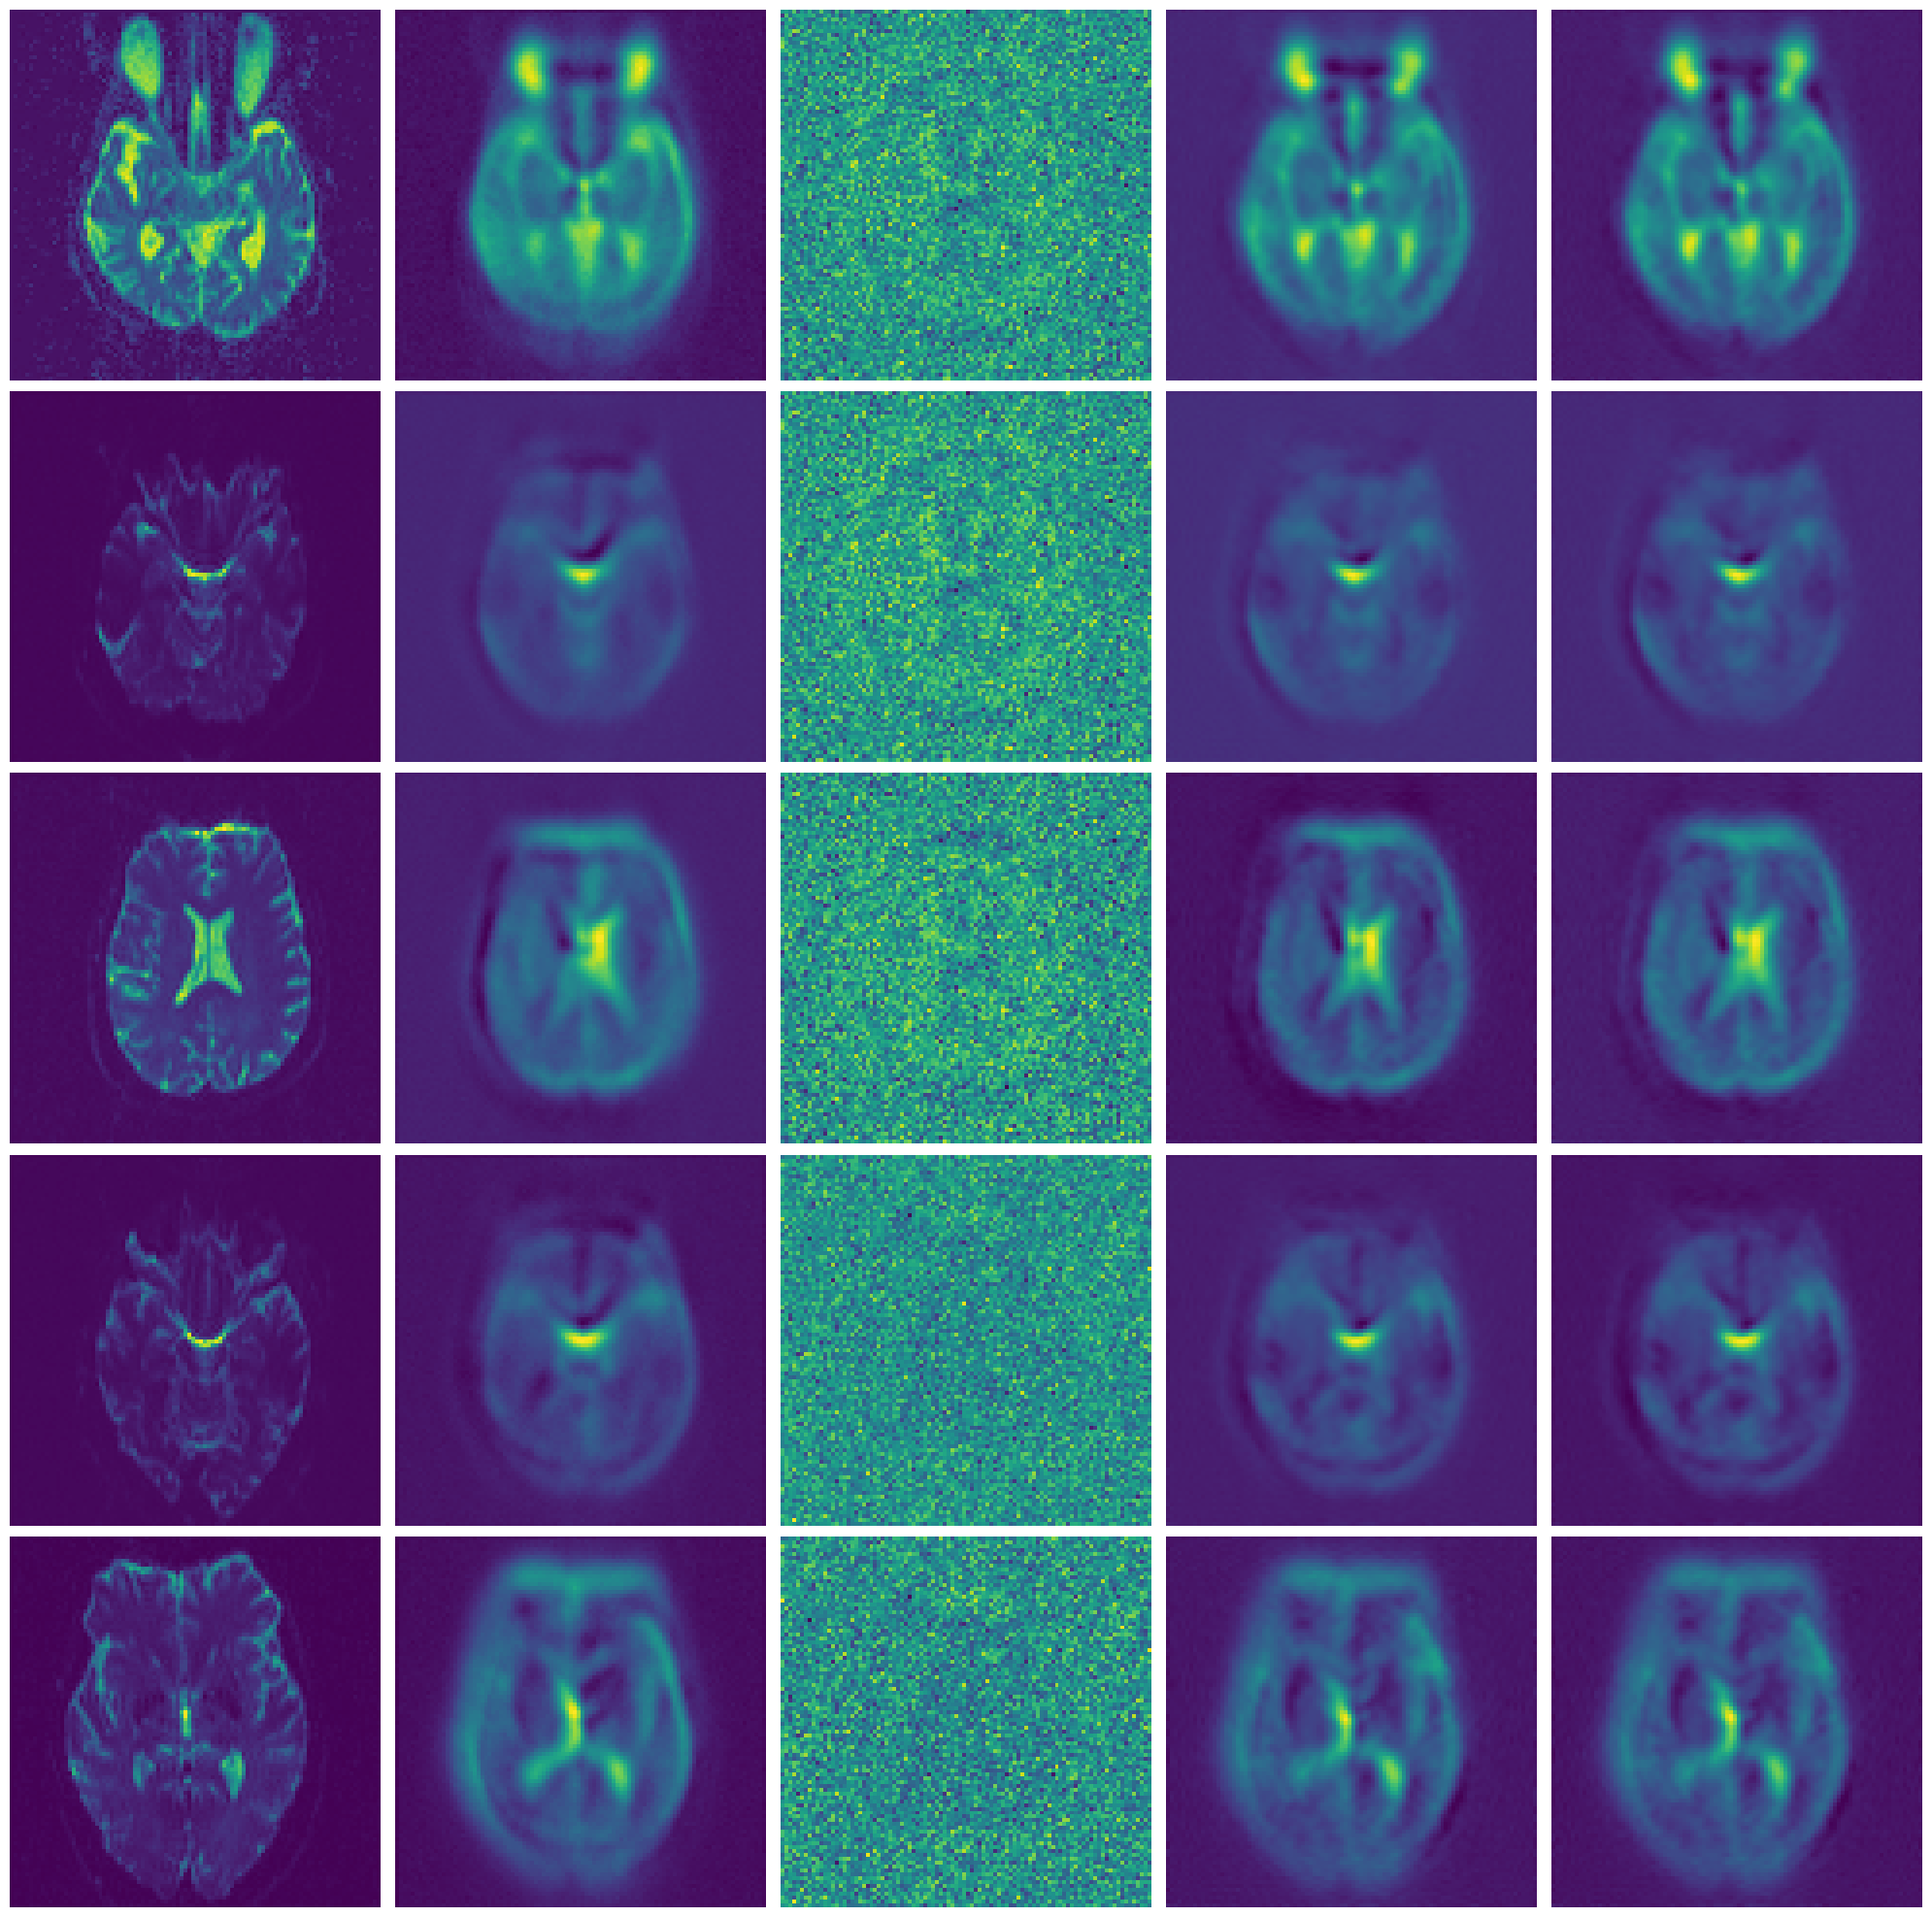

In [19]:
# PLotting test images reconstructed

#shift = 0
tryit = 67
image_list = [6,7, 63-50, 71-50, 16]
rows = len(image_list)

fig, axes = plt.subplots(rows, 5, figsize=(20,20))
plt.subplots_adjust(wspace=0.1, hspace=0.01)
#for i in range(rows):
k = 0
for i in image_list:    
    
    ax1, ax2, ax3, ax4, ax5 = axes[k]
    ax1.imshow(testImages[i][0])
    ax1.axis('off') # for removing axis
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax5.axis('off')
    #if(k==0):
        #ax1.set_title('Original', fontsize = 30)
    ax2.imshow(unhyb_rec_bAE_test[i][0])
    #if(k==0):
        #ax2.set_title('MLP-AE', fontsize = 30)
    ax3.imshow(unhyb_rec_rAE_test[i][0])
    #if(k==0):
        #ax3.set_title('AE-REG', fontsize = 30)
    ax4.imshow(hybrd_reconBase_test[i][0])
    #if(k==0):
        #ax4.set_title('Hybdrid MLP-AE', fontsize = 30)
    ax5.imshow(hybrd_reconReg_test[i][0])
    #if(k==0):
        #ax5.set_title('Hybdrid AE-REG', fontsize = 30)

    k = k+1
fig.tight_layout()
'''plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)'''
#plt.savefig('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders/Pictures_for_report/HybridTestImagesLatDim'+str(latent_dim)+'.png')                    
plt.show()

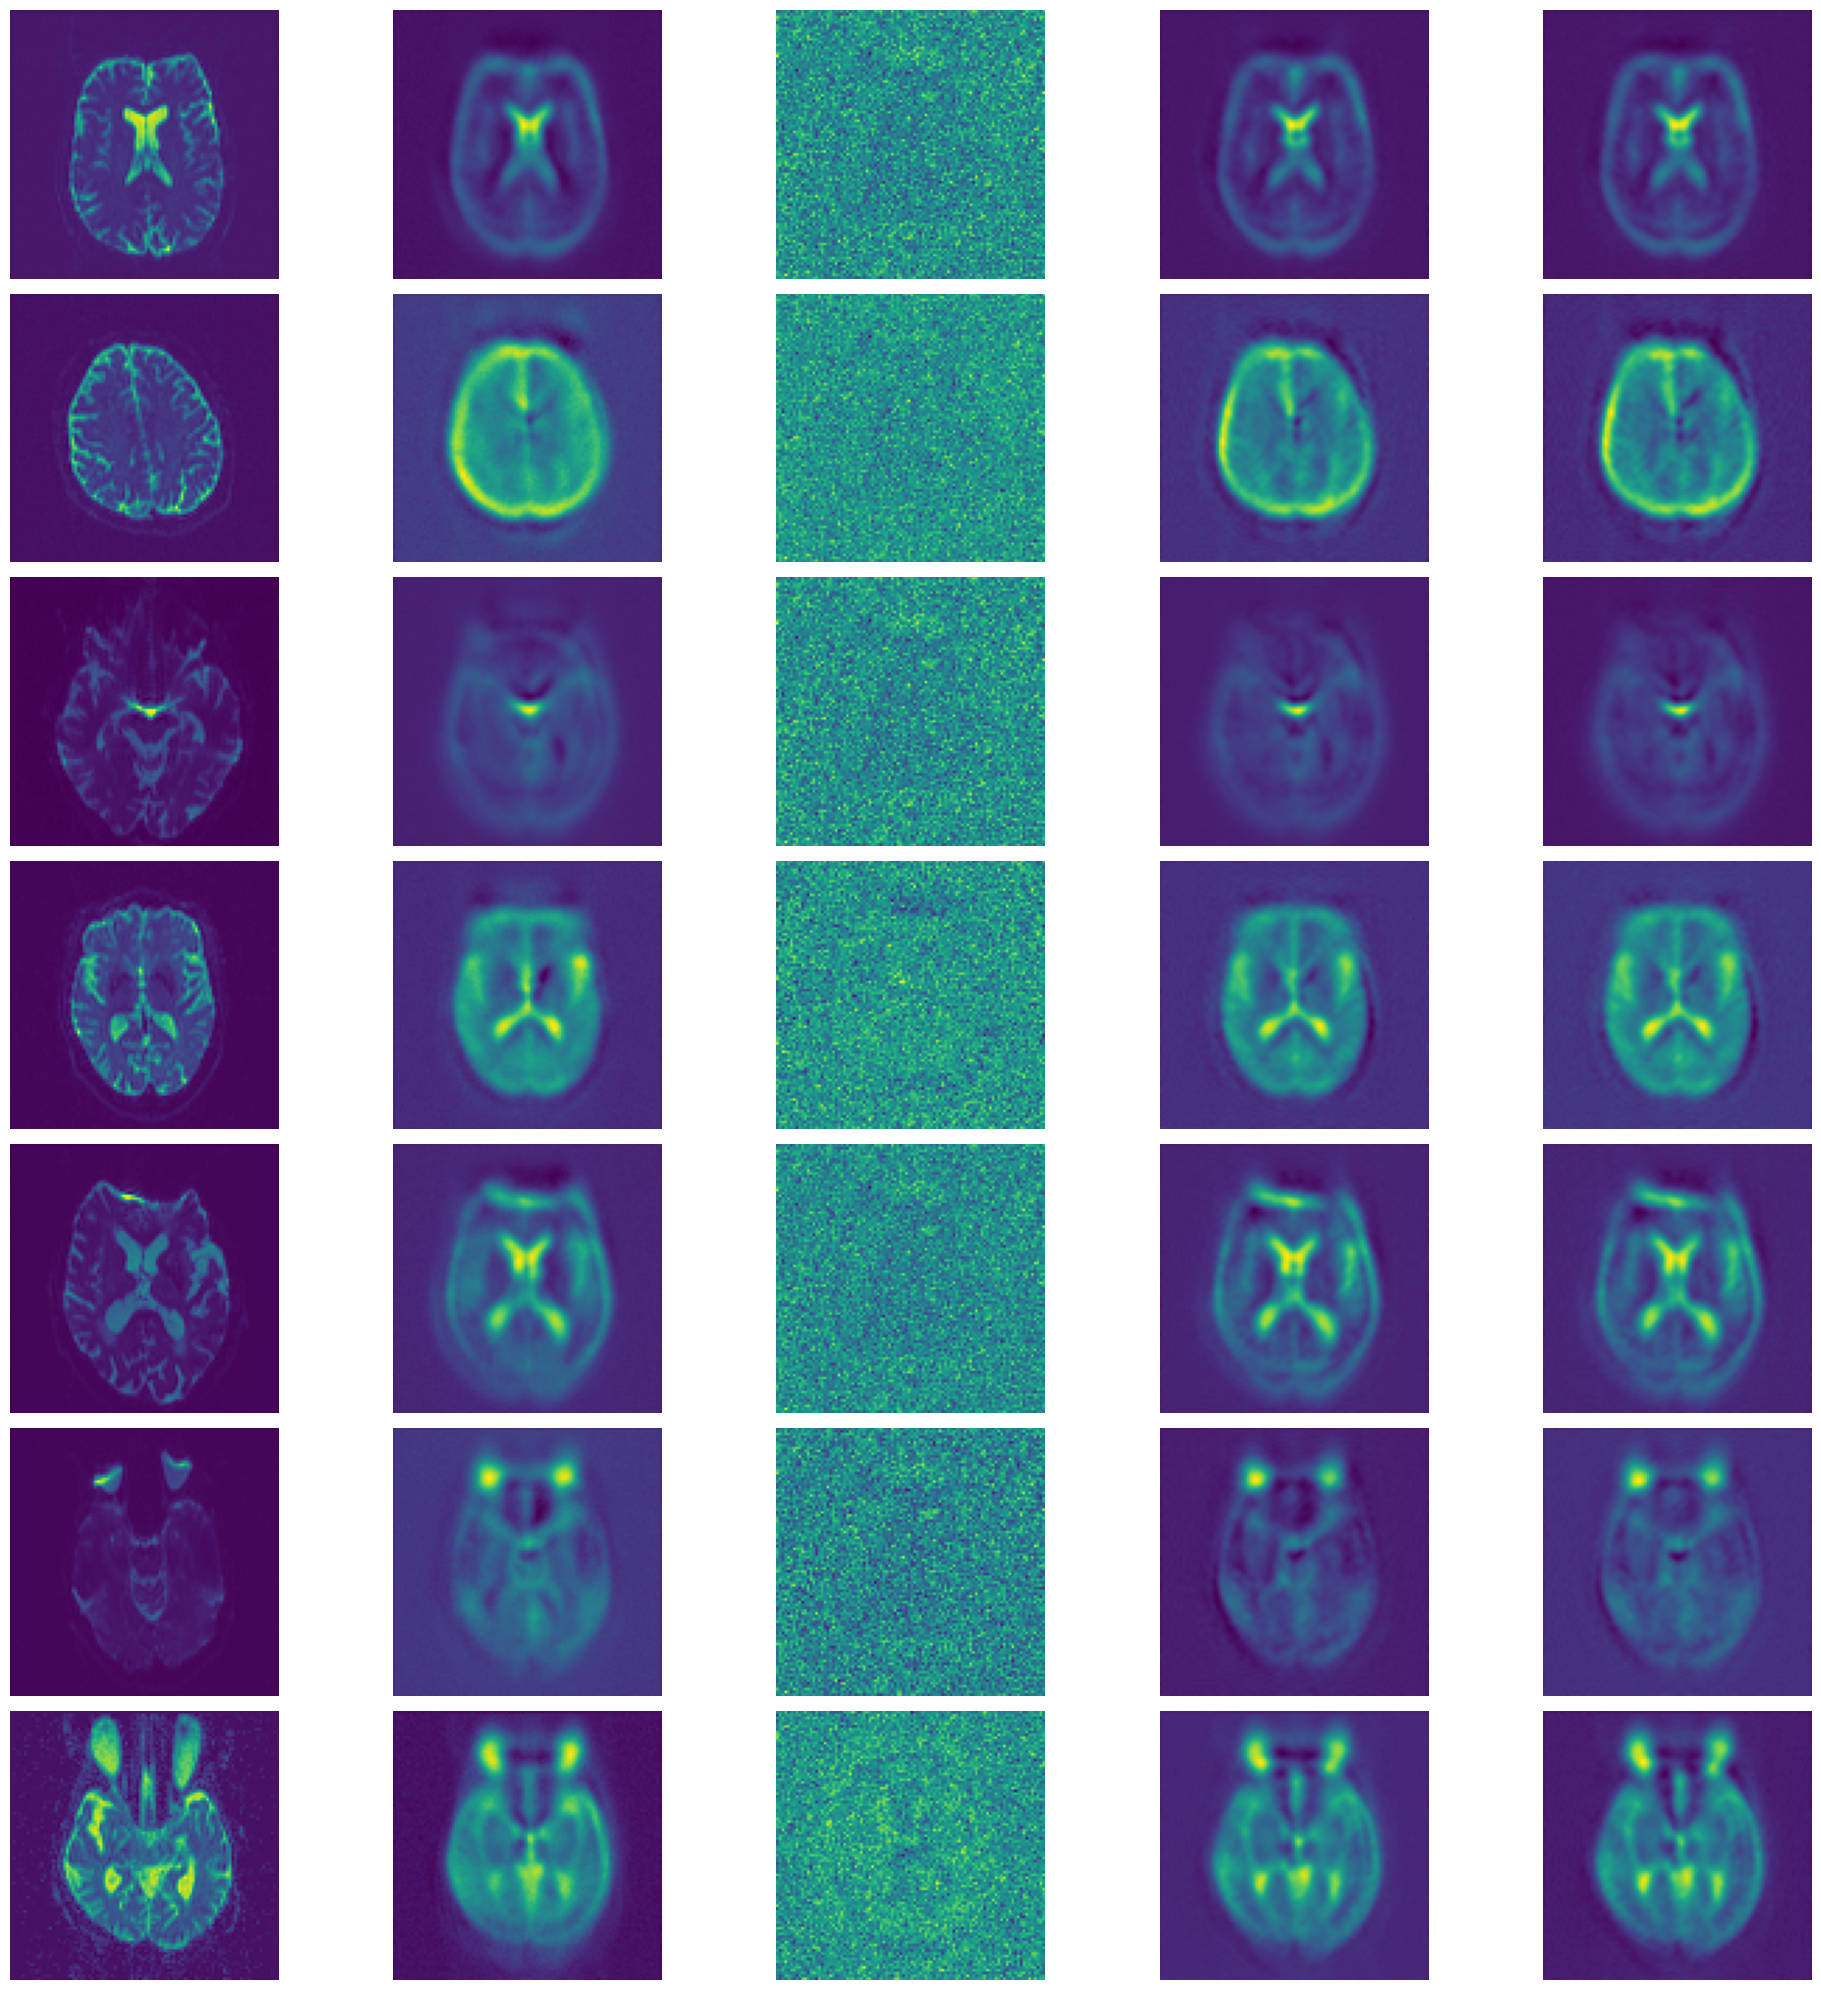

In [20]:
# PLotting test images reconstructed

#shift = 0
tryit = 0
image_list = [tryit, tryit+1, tryit+2, tryit+3, tryit+4, tryit+5, tryit+6]
rows = len(image_list)

fig, axes = plt.subplots(rows, 5, figsize=(20,20))
plt.subplots_adjust(wspace=0.1, hspace=0.01)
#for i in range(rows):
k = 0
for i in image_list:    
    
    ax1, ax2, ax3, ax4, ax5 = axes[k]
    ax1.imshow(testImages[i][0])
    ax1.axis('off') # for removing axis
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax5.axis('off')
    #if(k==0):
        #ax1.set_title('Original', fontsize = 30)
    ax2.imshow(unhyb_rec_bAE_test[i][0])
    #if(k==0):
        #ax2.set_title('MLP-AE', fontsize = 30)
    ax3.imshow(unhyb_rec_rAE_test[i][0])
    #if(k==0):
        #ax3.set_title('AE-REG', fontsize = 30)
    ax4.imshow(hybrd_reconBase_test[i][0])
    #if(k==0):
        #ax4.set_title('Hybdrid MLP-AE', fontsize = 30)
    ax5.imshow(hybrd_reconReg_test[i][0])
    #if(k==0):
        #ax5.set_title('Hybdrid AE-REG', fontsize = 30)

    k = k+1
fig.tight_layout()
'''plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)'''
#plt.savefig('/home/ramana44/topological-analysis-of-curved-spaces-and-hybridization-of-autoencoders/Pictures_for_report/HybridTestImagesLatDim'+str(latent_dim)+'.png')                    
plt.show()

In [21]:
'''ssim1 = calc_ssim(testImages, model_reg, type_=None)
ssim2 = calc_ssim(testImages, model_base, type_=None)'''

'ssim1 = calc_ssim(testImages, model_reg, type_=None)\nssim2 = calc_ssim(testImages, model_base, type_=None)'

In [22]:
#unhyb_base_prturb4_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_all_perturb4_recons_baseline_Lat'+str(latent_dim)+'_TDA'+str(frac)+'.pt')

unhyb_base_prturb4_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_all_perturb4_recons_baseline_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
unhyb_base_prturb4_recon = unhyb_base_prturb4_recon[:50]

unhyb_base_prturb4_recon = unhyb_base_prturb4_recon.reshape(50, 1, 96, 96)
unhyb_base_prturb4_recon = torch.tensor(unhyb_base_prturb4_recon, requires_grad=False)
unhyb_reg_prturb4_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_all_perturb4_recons_regularized_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt') 
unhyb_reg_prturb4_recon = unhyb_reg_prturb4_recon[:50]

unhyb_reg_prturb4_recon = unhyb_reg_prturb4_recon.reshape(50, 1, 96, 96)
unhyb_reg_prturb4_recon = torch.tensor(unhyb_reg_prturb4_recon, requires_grad=False)



hyb_base_prturb4_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_RK'+str(deg_quad)+'_all_perturb4_recons_RK_baseline_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
hyb_base_prturb4_recon = hyb_base_prturb4_recon.reshape(50, 1, 96, 96)
hyb_base_prturb4_recon = torch.tensor(hyb_base_prturb4_recon, requires_grad=False)
hyb_reg_prturb4_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_RK'+str(deg_quad)+'_all_perturb4_recons_RK_regularized_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
hyb_reg_prturb4_recon = hyb_reg_prturb4_recon.reshape(50, 1, 96, 96)
hyb_reg_prturb4_recon = torch.tensor(hyb_reg_prturb4_recon, requires_grad=False)


unhyb_base_prturb3_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_all_perturb3_recons_baseline_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
unhyb_base_prturb3_recon = unhyb_base_prturb3_recon[:50]
unhyb_base_prturb3_recon = unhyb_base_prturb3_recon.reshape(50, 1, 96, 96)
unhyb_base_prturb3_recon = torch.tensor(unhyb_base_prturb3_recon, requires_grad=False)
unhyb_reg_prturb3_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_all_perturb3_recons_regularized_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
unhyb_reg_prturb3_recon = unhyb_reg_prturb3_recon[:50]
unhyb_reg_prturb3_recon = unhyb_reg_prturb3_recon.reshape(50, 1, 96, 96)
unhyb_reg_prturb3_recon = torch.tensor(unhyb_reg_prturb3_recon, requires_grad=False)



hyb_base_prturb3_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_RK'+str(deg_quad)+'_all_perturb3_recons_RK_baseline_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
hyb_base_prturb3_recon = hyb_base_prturb3_recon.reshape(50, 1, 96, 96)
hyb_base_prturb3_recon = torch.tensor(hyb_base_prturb3_recon, requires_grad=False)
hyb_reg_prturb3_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_RK'+str(deg_quad)+'_all_perturb3_recons_RK_regularized_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
hyb_reg_prturb3_recon = hyb_reg_prturb3_recon.reshape(50, 1, 96, 96)
hyb_reg_prturb3_recon = torch.tensor(hyb_reg_prturb3_recon, requires_grad=False)


unhyb_base_prturb2_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_all_perturb2_recons_baseline_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
unhyb_base_prturb2_recon = unhyb_base_prturb2_recon[:50]
unhyb_base_prturb2_recon = unhyb_base_prturb2_recon.reshape(50, 1, 96, 96)
unhyb_base_prturb2_recon = torch.tensor(unhyb_base_prturb2_recon, requires_grad=False)
unhyb_reg_prturb2_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_all_perturb2_recons_regularized_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
unhyb_reg_prturb2_recon = unhyb_reg_prturb2_recon[:50]
unhyb_reg_prturb2_recon = unhyb_reg_prturb2_recon.reshape(50, 1, 96, 96)
unhyb_reg_prturb2_recon = torch.tensor(unhyb_reg_prturb2_recon, requires_grad=False)


hyb_base_prturb2_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_RK'+str(deg_quad)+'_all_perturb2_recons_RK_baseline_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
hyb_base_prturb2_recon = hyb_base_prturb2_recon.reshape(50, 1, 96, 96)
hyb_base_prturb2_recon = torch.tensor(hyb_base_prturb2_recon, requires_grad=False)
hyb_reg_prturb2_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_RK'+str(deg_quad)+'_all_perturb2_recons_RK_regularized_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
hyb_reg_prturb2_recon = hyb_reg_prturb2_recon.reshape(50, 1, 96, 96)
hyb_reg_prturb2_recon = torch.tensor(hyb_reg_prturb2_recon, requires_grad=False)


unhyb_base_prturb1_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_all_perturb1_recons_baseline_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
unhyb_base_prturb1_recon = unhyb_base_prturb1_recon[:50]
unhyb_base_prturb1_recon = unhyb_base_prturb1_recon.reshape(50, 1, 96, 96)
unhyb_base_prturb1_recon = torch.tensor(unhyb_base_prturb1_recon, requires_grad=False)
unhyb_reg_prturb1_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_all_perturb1_recons_regularized_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
unhyb_reg_prturb1_recon = unhyb_reg_prturb1_recon[:50]
unhyb_reg_prturb1_recon = unhyb_reg_prturb1_recon.reshape(50, 1, 96, 96)
unhyb_reg_prturb1_recon = torch.tensor(unhyb_reg_prturb1_recon, requires_grad=False)


hyb_base_prturb1_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_RK'+str(deg_quad)+'_all_perturb1_recons_RK_baseline_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
hyb_base_prturb1_recon = hyb_base_prturb1_recon.reshape(50, 1, 96, 96)
hyb_base_prturb1_recon = torch.tensor(hyb_base_prturb1_recon, requires_grad=False)
hyb_reg_prturb1_recon = torch.load('/home/ramana44/autoencoder_regulrization_conf_tasks/perturbedReconstructions/MRI_RK'+str(deg_quad)+'_all_perturb1_recons_RK_regularized_Lat'+str(latent_dim)+'_TDA'+str(frac)+'lot.pt')
hyb_reg_prturb1_recon = hyb_reg_prturb1_recon.reshape(50, 1, 96, 96)
hyb_reg_prturb1_recon = torch.tensor(hyb_reg_prturb1_recon, requires_grad=False)

/tmp/ipykernel_34923/3457958353.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unhyb_base_prturb4_recon = torch.tensor(unhyb_base_prturb4_recon, requires_grad=False)
/tmp/ipykernel_34923/3457958353.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unhyb_reg_prturb4_recon = torch.tensor(unhyb_reg_prturb4_recon, requires_grad=False)
/tmp/ipykernel_34923/3457958353.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hyb_base_prturb4_recon = torch.tensor(hyb_base_prturb4_recon, requires_grad=False)
/tmp/ipykernel_34923/3457958353.py:

In [23]:
hyb_base_prturb4_recon.shape

torch.Size([50, 1, 96, 96])

In [24]:
imno = 10

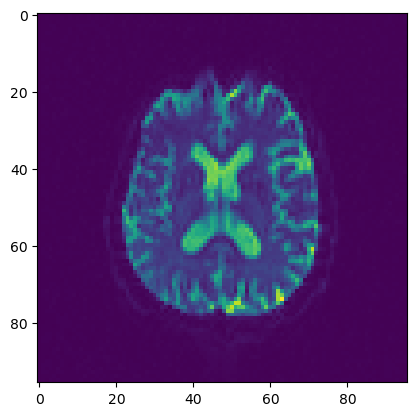

In [25]:
plt.imshow(testImages[imno][0])

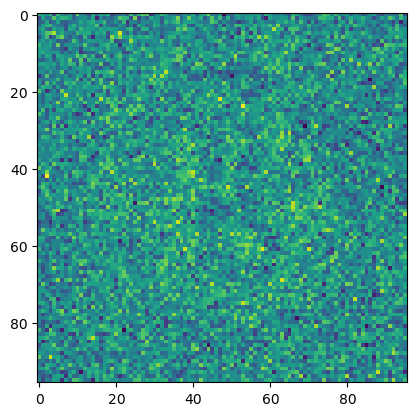

In [26]:
plt.imshow(unhyb_base_prturb4_recon[imno][0])

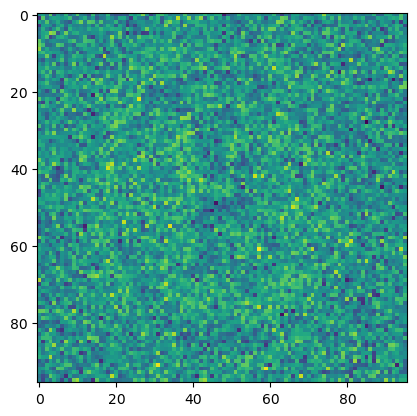

In [27]:
plt.imshow(unhyb_reg_prturb4_recon[imno][0])

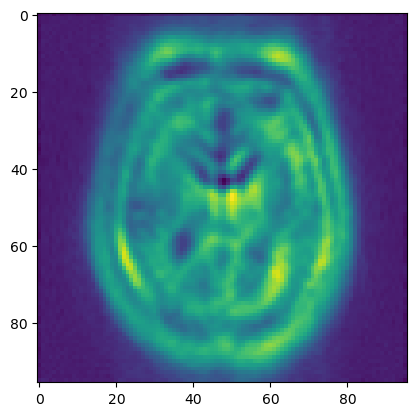

In [28]:
plt.imshow(hyb_base_prturb4_recon[imno][0])

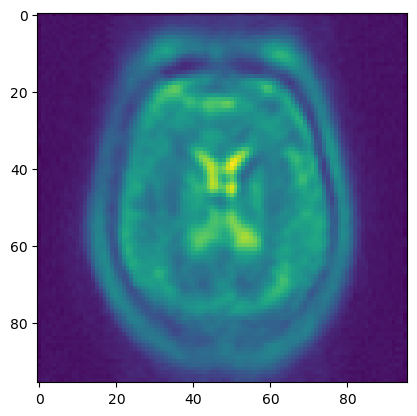

In [29]:
plt.imshow(hyb_reg_prturb4_recon[imno][0])

In [30]:
# Get rid of negatives again to the perturbed
 
hyb_base_prturb4_recon[np.where(hyb_base_prturb4_recon < 0.0)] = 0
hyb_base_prturb3_recon[np.where(hyb_base_prturb3_recon < 0.0)] = 0
hyb_base_prturb2_recon[np.where(hyb_base_prturb2_recon < 0.0)] = 0
hyb_base_prturb1_recon[np.where(hyb_base_prturb1_recon < 0.0)] = 0


hyb_reg_prturb4_recon[np.where(hyb_reg_prturb4_recon < 0.0)] = 0
hyb_reg_prturb3_recon[np.where(hyb_reg_prturb3_recon < 0.0)] = 0
hyb_reg_prturb2_recon[np.where(hyb_reg_prturb2_recon < 0.0)] = 0
hyb_reg_prturb1_recon[np.where(hyb_reg_prturb1_recon < 0.0)] = 0

In [31]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from matplotlib.colors import Normalize


ssimlists_unhyb_base = []
ssimlists_unhyb_reg = []
ssimlists_hyb_base = []
ssimlists_hyb_reg = []

ssimlists_perturb4_hyb_base = []
ssimlists_perturb4_hyb_reg = []
ssimlists_perturb4_base = []
ssimlists_perturb4_reg = []

ssimlists_perturb3_hyb_base = []
ssimlists_perturb3_hyb_reg = []
ssimlists_perturb3_base = []
ssimlists_perturb3_reg = []

ssimlists_perturb2_hyb_base = []
ssimlists_perturb2_hyb_reg = []
ssimlists_perturb2_base = []
ssimlists_perturb2_reg = []

ssimlists_perturb1_hyb_base = []
ssimlists_perturb1_hyb_reg = []
ssimlists_perturb1_base = []
ssimlists_perturb1_reg = []

##############################################################################################

psnrlists_unhyb_base = []
psnrlists_unhyb_reg = []
psnrlists_hyb_base = []
psnrlists_hyb_reg = []

psnrlists_perturb4_base = []
psnrlists_perturb4_reg = []
psnrlists_perturb4_hyb_base = []
psnrlists_perturb4_hyb_reg = []

psnrlists_perturb3_base = []
psnrlists_perturb3_reg = []
psnrlists_perturb3_hyb_base = []
psnrlists_perturb3_hyb_reg = []

psnrlists_perturb2_base = []
psnrlists_perturb2_reg = []
psnrlists_perturb2_hyb_base = []
psnrlists_perturb2_hyb_reg = []

psnrlists_perturb1_base = []
psnrlists_perturb1_reg = []
psnrlists_perturb1_hyb_base = []
psnrlists_perturb1_hyb_reg = []

for i in range(len(testImages)):

    testImage_normal = Normalize()(testImages[i])
    recon_normal_unhyb_base = Normalize()(unhyb_rec_bAE_test[i])
    recon_normal_unhyb_reg = Normalize()(unhyb_rec_rAE_test[i])
    recon_normal_hyb_base = Normalize()(hybrd_reconBase_test[i])
    recon_normal_hyb_reg = Normalize()(hybrd_reconReg_test[i])

    recon_normal_unhyb_base_perturb4 = Normalize()(unhyb_base_prturb4_recon[i])
    recon_normal_unhyb_reg_perturb4 = Normalize()(unhyb_reg_prturb4_recon[i])
    recon_normal_hyb_base_perturb4 = Normalize()(hyb_base_prturb4_recon[i])
    recon_normal_hyb_reg_perturb4 = Normalize()(hyb_reg_prturb4_recon[i])

    recon_normal_unhyb_base_perturb3 = Normalize()(unhyb_base_prturb3_recon[i])
    recon_normal_unhyb_reg_perturb3 = Normalize()(unhyb_reg_prturb3_recon[i])
    recon_normal_hyb_base_perturb3 = Normalize()(hyb_base_prturb3_recon[i])
    recon_normal_hyb_reg_perturb3 = Normalize()(hyb_reg_prturb3_recon[i])

    recon_normal_unhyb_base_perturb2 = Normalize()(unhyb_base_prturb2_recon[i])
    recon_normal_unhyb_reg_perturb2 = Normalize()(unhyb_reg_prturb2_recon[i])
    recon_normal_hyb_base_perturb2 = Normalize()(hyb_base_prturb2_recon[i])
    recon_normal_hyb_reg_perturb2 = Normalize()(hyb_reg_prturb2_recon[i])

    recon_normal_unhyb_base_perturb1 = Normalize()(unhyb_base_prturb1_recon[i])
    recon_normal_unhyb_reg_perturb1 = Normalize()(unhyb_reg_prturb1_recon[i])
    recon_normal_hyb_base_perturb1 = Normalize()(hyb_base_prturb1_recon[i])
    recon_normal_hyb_reg_perturb1 = Normalize()(hyb_reg_prturb1_recon[i])

    ############################################################################################

    ssimlists_unhyb_base.append(max(ssim(testImage_normal[0], recon_normal_unhyb_base[0], data_range=1.), 0))
    ssimlists_unhyb_reg.append(max(ssim(testImage_normal[0], recon_normal_unhyb_reg[0], data_range=1.), 0))
    ssimlists_hyb_base.append(max(ssim(testImage_normal[0], recon_normal_hyb_base[0], data_range=1.), 0))
    ssimlists_hyb_reg.append(max(ssim(testImage_normal[0], recon_normal_hyb_reg[0], data_range=1.), 0))

    ssimlists_perturb4_base.append(max(ssim(testImage_normal[0], recon_normal_unhyb_base_perturb4[0], data_range=1.), 0))
    ssimlists_perturb4_reg.append(max(ssim(testImage_normal[0], recon_normal_unhyb_reg_perturb4[0], data_range=1.), 0))
    ssimlists_perturb4_hyb_base.append(max(ssim(testImage_normal[0], recon_normal_hyb_base_perturb4[0], data_range=1.), 0))
    ssimlists_perturb4_hyb_reg.append(max(ssim(testImage_normal[0], recon_normal_hyb_reg_perturb4[0], data_range=1.), 0))

    ssimlists_perturb3_base.append(max(ssim(testImage_normal[0], recon_normal_unhyb_base_perturb3[0], data_range=1.), 0))
    ssimlists_perturb3_reg.append(max(ssim(testImage_normal[0], recon_normal_unhyb_reg_perturb3[0], data_range=1.), 0))
    ssimlists_perturb3_hyb_base.append(max(ssim(testImage_normal[0], recon_normal_hyb_base_perturb3[0], data_range=1.), 0))
    ssimlists_perturb3_hyb_reg.append(max(ssim(testImage_normal[0], recon_normal_hyb_reg_perturb3[0], data_range=1.), 0))

    ssimlists_perturb2_base.append(max(ssim(testImage_normal[0], recon_normal_unhyb_base_perturb2[0], data_range=1.), 0))
    ssimlists_perturb2_reg.append(max(ssim(testImage_normal[0], recon_normal_unhyb_reg_perturb2[0], data_range=1.), 0))
    ssimlists_perturb2_hyb_base.append(max(ssim(testImage_normal[0], recon_normal_hyb_base_perturb2[0], data_range=1.), 0))
    ssimlists_perturb2_hyb_reg.append(max(ssim(testImage_normal[0], recon_normal_hyb_reg_perturb2[0], data_range=1.), 0))

    ssimlists_perturb1_base.append(max(ssim(testImage_normal[0], recon_normal_unhyb_base_perturb1[0], data_range=1.), 0))
    ssimlists_perturb1_reg.append(max(ssim(testImage_normal[0], recon_normal_unhyb_reg_perturb1[0], data_range=1.), 0))
    ssimlists_perturb1_hyb_base.append(max(ssim(testImage_normal[0], recon_normal_hyb_base_perturb1[0], data_range=1.), 0))
    ssimlists_perturb1_hyb_reg.append(max(ssim(testImage_normal[0], recon_normal_hyb_reg_perturb1[0], data_range=1.), 0))

    #############################################################################################

    psnrlists_unhyb_base.append(psnr(testImage_normal[0], recon_normal_unhyb_base[0], data_range=1.))
    psnrlists_unhyb_reg.append(psnr(testImage_normal[0], recon_normal_unhyb_reg[0], data_range=1.))
    psnrlists_hyb_base.append(psnr(testImage_normal[0], recon_normal_hyb_base[0], data_range=1.))
    psnrlists_hyb_reg.append(psnr(testImage_normal[0], recon_normal_hyb_reg[0], data_range=1.))

    psnrlists_perturb4_base.append(psnr(testImage_normal[0], recon_normal_unhyb_base_perturb4[0], data_range=1.))
    psnrlists_perturb4_reg.append(psnr(testImage_normal[0], recon_normal_unhyb_reg_perturb4[0], data_range=1.))
    psnrlists_perturb4_hyb_base.append(psnr(testImage_normal[0], recon_normal_hyb_base_perturb4[0], data_range=1.))
    psnrlists_perturb4_hyb_reg.append(psnr(testImage_normal[0], recon_normal_hyb_reg_perturb4[0], data_range=1.))

    psnrlists_perturb3_base.append(psnr(testImage_normal[0], recon_normal_unhyb_base_perturb3[0], data_range=1.))
    psnrlists_perturb3_reg.append(psnr(testImage_normal[0], recon_normal_unhyb_reg_perturb3[0], data_range=1.))
    psnrlists_perturb3_hyb_base.append(psnr(testImage_normal[0], recon_normal_hyb_base_perturb3[0], data_range=1.))
    psnrlists_perturb3_hyb_reg.append(psnr(testImage_normal[0], recon_normal_hyb_reg_perturb3[0], data_range=1.))

    psnrlists_perturb2_base.append(psnr(testImage_normal[0], recon_normal_unhyb_base_perturb2[0], data_range=1.))
    psnrlists_perturb2_reg.append(psnr(testImage_normal[0], recon_normal_unhyb_reg_perturb2[0], data_range=1.))
    psnrlists_perturb2_hyb_base.append(psnr(testImage_normal[0], recon_normal_hyb_base_perturb2[0], data_range=1.))
    psnrlists_perturb2_hyb_reg.append(psnr(testImage_normal[0], recon_normal_hyb_reg_perturb2[0], data_range=1.))

    psnrlists_perturb1_base.append(psnr(testImage_normal[0], recon_normal_unhyb_base_perturb1[0], data_range=1.))
    psnrlists_perturb1_reg.append(psnr(testImage_normal[0], recon_normal_unhyb_reg_perturb1[0], data_range=1.))
    psnrlists_perturb1_hyb_base.append(psnr(testImage_normal[0], recon_normal_hyb_base_perturb1[0], data_range=1.))
    psnrlists_perturb1_hyb_reg.append(psnr(testImage_normal[0], recon_normal_hyb_reg_perturb1[0], data_range=1.))




In [32]:
# reconstruction loss after training the model completely
loss_tre = torch.mean(((unhyb_base_prturb4_recon - testImages)**2)*0.5)
loss_tre

tensor(0.8105)

In [33]:
# reconstruction loss after training the model completely
loss_tre = torch.mean(((unhyb_reg_prturb4_recon - testImages)**2)*0.5)
loss_tre

tensor(0.6752)

SSIM of reconstruction on test data


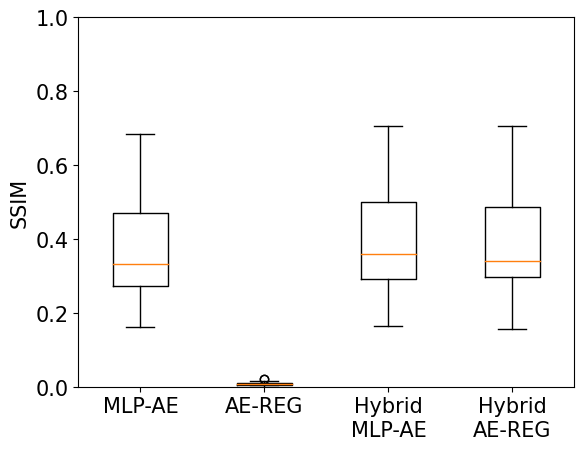

In [34]:
import matplotlib.pyplot as plt
import numpy as np
print('SSIM of reconstruction on test data')
fracs = ['MLP-AE','AE-REG', 'Hybrid\nMLP-AE', 'Hybrid\nAE-REG']
#ssims = np.load('/path/to/folder/SSIM/SSIM_data_base_test.npy')
ssims = [ssimlists_unhyb_base, ssimlists_unhyb_reg, ssimlists_hyb_base, ssimlists_hyb_reg]
fig1, ax1 = plt.subplots()
#ax1.set_title('SSIM of reconstruction on test data')
ax1.boxplot(list(ssims))
#ax1.set_xlabel('Models', fontsize=16)
ax1.set_ylabel('SSIM', fontsize=15)
ax1.set_ylim([0,1])
plt.xticks([1, 2, 3, 4], [str(s) for s in fracs], fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/ramana44/Pictures_for_report/SSIM_directReconOfTestData_LossBal'+str(alpha)+'Lat_dim'+str(latent_dim)+'TDA_'+str(frac)+'RK_deg_'+str(deg_quad)+'.png')
plt.show()


PSNR of reconstruction on test data


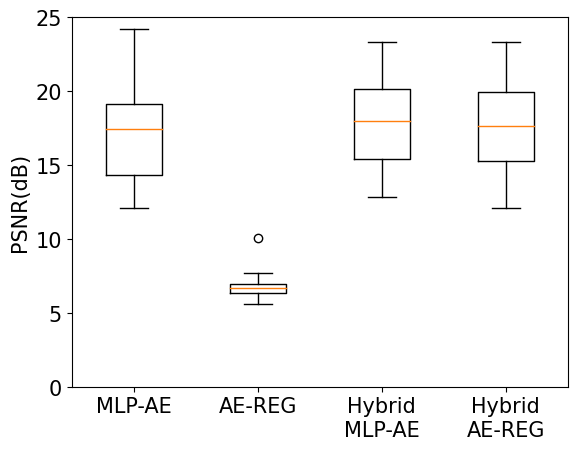

In [35]:
#import matplotlib.pyplot as plt
#import numpy as np
print('PSNR of reconstruction on test data')
fracs = ['MLP-AE','AE-REG', 'Hybrid\nMLP-AE', 'Hybrid\nAE-REG']
#ssims = np.load('/path/to/folder/SSIM/SSIM_data_base_test.npy')
psnrs = [psnrlists_unhyb_base, psnrlists_unhyb_reg, psnrlists_hyb_base, psnrlists_hyb_reg]
fig1, ax1 = plt.subplots()
#ax1.set_title('PSNR of reconstruction on test data')
ax1.boxplot(list(psnrs))
#ax1.set_xlabel('Models', fontsize=16)
ax1.set_ylabel('PSNR(dB)', fontsize=15)
ax1.set_ylim([0,25])
plt.xticks([1, 2, 3, 4], [str(s) for s in fracs], fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/ramana44/Pictures_for_report/PSNR_directReconOfTestData_LossBal'+str(alpha)+'Lat_dim'+str(latent_dim)+'TDA_'+str(frac)+'RK_deg_'+str(deg_quad)+'.png')
plt.show()

PSNR of reconstruction of 70 % noised  test data


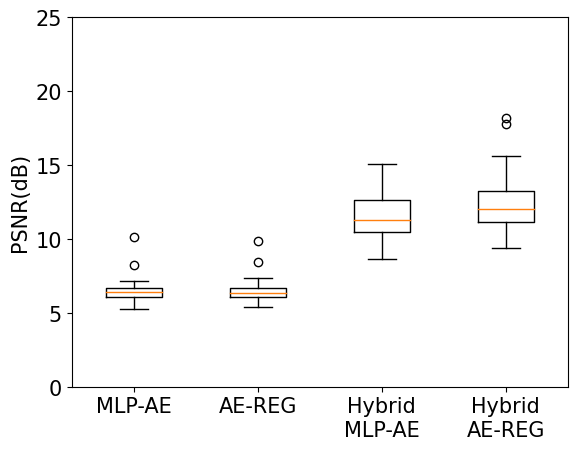

6.459455032026028
6.4765318711841235
11.567007424772799
12.366622064764655


In [36]:
#Perturbation test for noise

print('PSNR of reconstruction of 70 % noised  test data')
fracs = ['MLP-AE','AE-REG', 'Hybrid\nMLP-AE', 'Hybrid\nAE-REG']
#ssims = np.load('/path/to/folder/SSIM/SSIM_data_base_test.npy')
psnrs = [psnrlists_perturb4_base, psnrlists_perturb4_reg, psnrlists_perturb4_hyb_base,psnrlists_perturb4_hyb_reg]
fig1, ax1 = plt.subplots()
#ax1.set_title('PSNR of reconstruction of 70 % noised  test data')
ax1.boxplot(list(psnrs))
#ax1.set_xlabel('Models', fontsize=10)
ax1.set_ylabel('PSNR(dB)', fontsize=15)
ax1.set_ylim([0,25])
plt.xticks([1, 2, 3, 4], [str(s) for s in fracs], fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/ramana44/Pictures_for_report/PSNR_ReconOf70percentNoiseedTestData_LossBal'+str(alpha)+'Lat_dim'+str(latent_dim)+'TDA_'+str(frac)+'RK_deg_'+str(deg_quad)+'.png')
plt.show()

print(np.mean(psnrlists_perturb4_base))
print(np.mean(psnrlists_perturb4_reg))
print(np.mean(psnrlists_perturb4_hyb_base))
print(np.mean(psnrlists_perturb4_hyb_reg))

PSNR of reconstruction of 50 % noised  test data


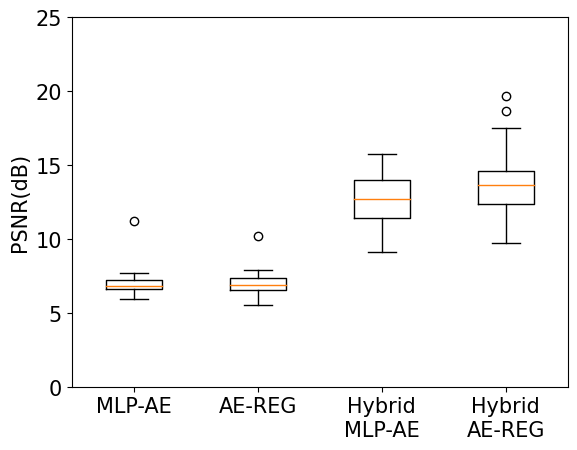

6.960319842115473
6.956972700876313
12.545805887900496
13.760443218956699


In [37]:
#Perturbation test for noise
print('PSNR of reconstruction of 50 % noised  test data')
fracs = ['MLP-AE','AE-REG', 'Hybrid\nMLP-AE', 'Hybrid\nAE-REG']
#fracs = ['MLP-AE','AE-REG', 'Hybrid MLP-AE', 'Hybrid AE-REG']
#ssims = np.load('/path/to/folder/SSIM/SSIM_data_base_test.npy')
psnrs = [psnrlists_perturb3_base, psnrlists_perturb3_reg, psnrlists_perturb3_hyb_base,psnrlists_perturb3_hyb_reg]
fig1, ax1 = plt.subplots()
#ax1.set_title('PSNR of reconstruction of 50 % noised  test data')
ax1.boxplot(list(psnrs))
#ax1.set_xlabel('Models', fontsize=10)
ax1.set_ylabel('PSNR(dB)', fontsize=15)
ax1.set_ylim([0,25])
plt.xticks([1, 2, 3, 4], [str(s) for s in fracs], fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/ramana44/Pictures_for_report/PSNR_ReconOf50percentNoiseedTestData_LossBal'+str(alpha)+'Lat_dim'+str(latent_dim)+'TDA_'+str(frac)+'RK_deg_'+str(deg_quad)+'.png')
plt.show()

print(np.mean(psnrlists_perturb3_base))
print(np.mean(psnrlists_perturb3_reg))
print(np.mean(psnrlists_perturb3_hyb_base))
print(np.mean(psnrlists_perturb3_hyb_reg))

PSNR of reconstruction of 20 % noised  test data


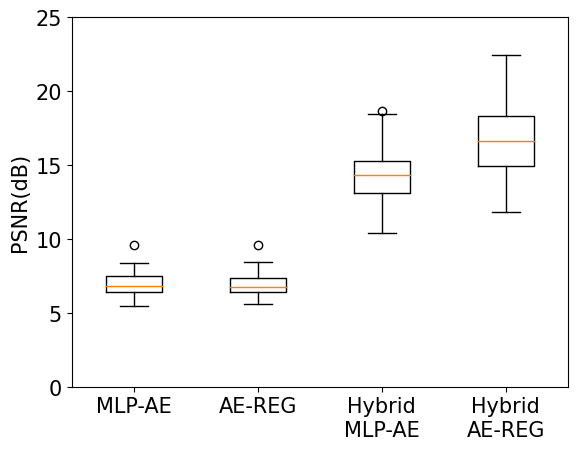

6.965649140636003
6.913147842325096
14.216227299792445
16.78411056128907


In [38]:
#Perturbation test for noise
print('PSNR of reconstruction of 20 % noised  test data')
fracs = ['MLP-AE','AE-REG', 'Hybrid\nMLP-AE', 'Hybrid\nAE-REG']
#ssims = np.load('/path/to/folder/SSIM/SSIM_data_base_test.npy')
psnrs = [psnrlists_perturb2_base, psnrlists_perturb2_reg, psnrlists_perturb2_hyb_base,psnrlists_perturb2_hyb_reg]
fig1, ax1 = plt.subplots()
#ax1.set_title('PSNR of reconstruction of 20 % noised  test data')
ax1.boxplot(list(psnrs))
#ax1.set_xlabel('Models', fontsize=16)
ax1.set_ylabel('PSNR(dB)', fontsize=15)
ax1.set_ylim([0,25])
plt.xticks([1, 2, 3, 4], [str(s) for s in fracs], fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/ramana44/Pictures_for_report/PSNR_ReconOf20percentNoiseedTestData_LossBal'+str(alpha)+'Lat_dim'+str(latent_dim)+'TDA_'+str(frac)+'RK_deg_'+str(deg_quad)+'.png')
plt.show()

print(np.mean(psnrlists_perturb2_base))
print(np.mean(psnrlists_perturb2_reg))
print(np.mean(psnrlists_perturb2_hyb_base))
print(np.mean(psnrlists_perturb2_hyb_reg))

PSNR of reconstruction of 10 % noised  test data


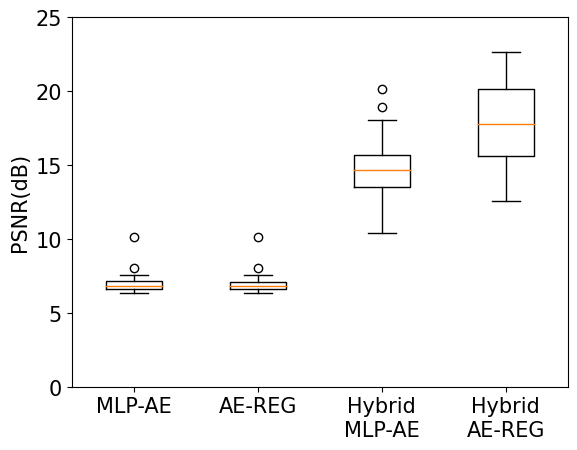

6.937529691109192
6.925875326377134
14.718995045565618
17.725081217354276


In [39]:
#Perturbation test for noise
print('PSNR of reconstruction of 10 % noised  test data')
fracs = ['MLP-AE','AE-REG', 'Hybrid\nMLP-AE', 'Hybrid\nAE-REG']
#ssims = np.load('/path/to/folder/SSIM/SSIM_data_base_test.npy')
psnrs = [psnrlists_perturb1_base, psnrlists_perturb1_reg, psnrlists_perturb1_hyb_base,psnrlists_perturb1_hyb_reg]
fig1, ax1 = plt.subplots()
#ax1.set_title('PSNR of reconstruction of 10 % noised  test data')
ax1.boxplot(list(psnrs))
#ax1.set_xlabel('Models', fontsize=10)
ax1.set_ylabel('PSNR(dB)', fontsize=15)
ax1.set_ylim([0,25])
plt.xticks([1, 2, 3, 4], [str(s) for s in fracs], fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/ramana44/Pictures_for_report/PSNR_ReconOf10percentNoiseedTestData_LossBal'+str(alpha)+'Lat_dim'+str(latent_dim)+'TDA_'+str(frac)+'RK_deg_'+str(deg_quad)+'.png')
plt.show()

print(np.mean(psnrlists_perturb1_base))
print(np.mean(psnrlists_perturb1_reg))
print(np.mean(psnrlists_perturb1_hyb_base))
print(np.mean(psnrlists_perturb1_hyb_reg))

SSIM of reconstruction of 70 % noised  test data


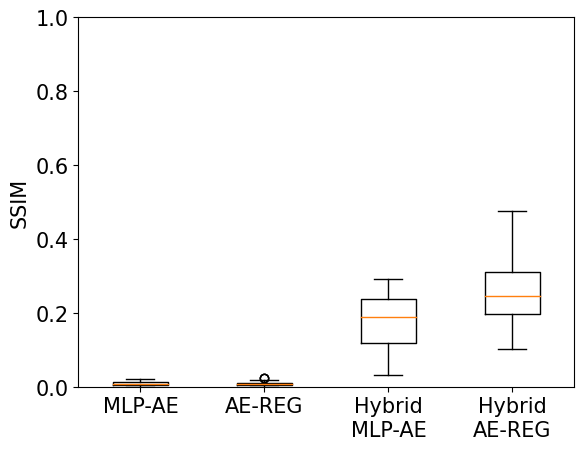

0.009373990244693195
0.009243756552865917
0.18057584032664825
0.2532075167480998


In [40]:
#Perturbation test for noise
print('SSIM of reconstruction of 70 % noised  test data')
fracs = ['MLP-AE','AE-REG', 'Hybrid\nMLP-AE', 'Hybrid\nAE-REG']
#ssims = np.load('/path/to/folder/SSIM/SSIM_data_base_test.npy')
ssims = [ssimlists_perturb4_base, ssimlists_perturb4_reg, ssimlists_perturb4_hyb_base, ssimlists_perturb4_hyb_reg]
fig1, ax1 = plt.subplots()
#ax1.set_title('SSIM of reconstruction of 70 % noised  test data')
ax1.boxplot(list(ssims))
#ax1.set_xlabel('Models', fontsize=16)
ax1.set_ylabel('SSIM', fontsize=15)
ax1.set_ylim([0,1])
plt.xticks([1, 2, 3, 4], [str(s) for s in fracs], fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/ramana44/Pictures_for_report/SSIM_ReconOf70percentNoiseedTestData_LossBal'+str(alpha)+'Lat_dim'+str(latent_dim)+'TDA_'+str(frac)+'RK_deg_'+str(deg_quad)+'.png')
plt.show()

print(np.mean(ssimlists_perturb4_base))
print(np.mean(ssimlists_perturb4_reg))
print(np.mean(ssimlists_perturb4_hyb_base))
print(np.mean(ssimlists_perturb4_hyb_reg))

SSIM of reconstruction of 50 % noised  test data


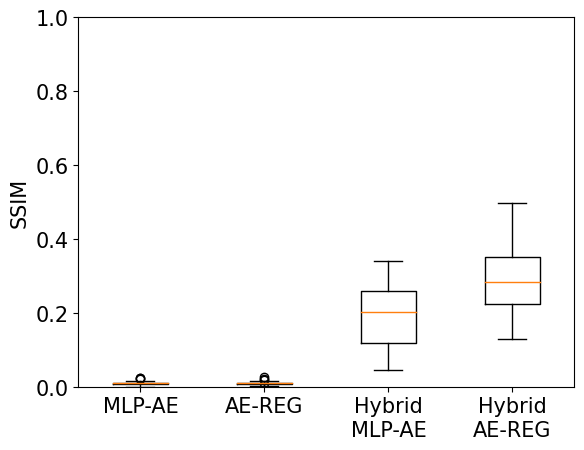

0.010174145796713718
0.010442957532456386
0.18955262305908754
0.29213653653955785


In [41]:
#Perturbation test for noise

print('SSIM of reconstruction of 50 % noised  test data')
fracs = ['MLP-AE','AE-REG', 'Hybrid\nMLP-AE', 'Hybrid\nAE-REG']
#ssims = np.load('/path/to/folder/SSIM/SSIM_data_base_test.npy')
ssims = [ssimlists_perturb3_base, ssimlists_perturb3_reg, ssimlists_perturb3_hyb_base, ssimlists_perturb3_hyb_reg]
fig1, ax1 = plt.subplots()
#ax1.set_title('SSIM of reconstruction of 50 % noised  test data')
ax1.boxplot(list(ssims))
#ax1.set_xlabel('Models', fontsize=10)
ax1.set_ylabel('SSIM', fontsize=15)
ax1.set_ylim([0,1])
plt.xticks([1, 2, 3, 4], [str(s) for s in fracs], fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/ramana44/Pictures_for_report/SSIM_ReconOf50percentNoiseedTestData_LossBal'+str(alpha)+'Lat_dim'+str(latent_dim)+'TDA_'+str(frac)+'RK_deg_'+str(deg_quad)+'.png')
plt.show()

print(np.mean(ssimlists_perturb3_base))
print(np.mean(ssimlists_perturb3_reg))
print(np.mean(ssimlists_perturb3_hyb_base))
print(np.mean(ssimlists_perturb3_hyb_reg))

SSIM of reconstruction of 20 % noised  test data


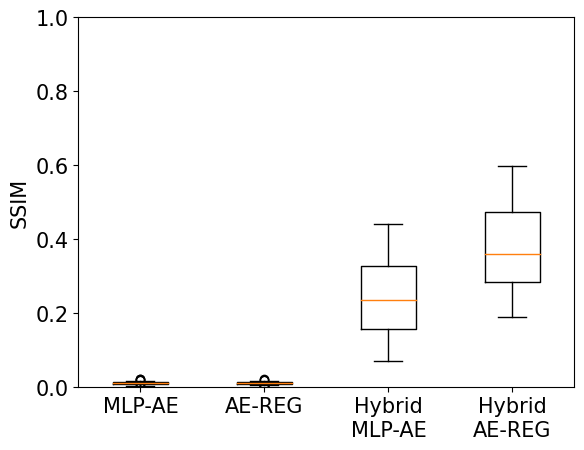

0.010681491979496482
0.010404755431616177
0.24139236070974018
0.3805724076984186


In [42]:
#Perturbation test for noise
print('SSIM of reconstruction of 20 % noised  test data')
fracs = ['MLP-AE','AE-REG', 'Hybrid\nMLP-AE', 'Hybrid\nAE-REG']
#ssims = np.load('/path/to/folder/SSIM/SSIM_data_base_test.npy')
ssims = [ssimlists_perturb2_base, ssimlists_perturb2_reg, ssimlists_perturb2_hyb_base, ssimlists_perturb2_hyb_reg]
fig1, ax1 = plt.subplots()
#ax1.set_title('SSIM of reconstruction of 20 % noised  test data')
ax1.boxplot(list(ssims))
#ax1.set_xlabel('Models', fontsize=15)
ax1.set_ylabel('SSIM', fontsize=15)
ax1.set_ylim([0,1])
plt.xticks([1, 2, 3, 4], [str(s) for s in fracs], fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/ramana44/Pictures_for_report/SSIM_ReconOf20percentNoiseedTestData_LossBal'+str(alpha)+'Lat_dim'+str(latent_dim)+'TDA_'+str(frac)+'RK_deg_'+str(deg_quad)+'.png')
plt.show()

print(np.mean(ssimlists_perturb2_base))
print(np.mean(ssimlists_perturb2_reg))
print(np.mean(ssimlists_perturb2_hyb_base))
print(np.mean(ssimlists_perturb2_hyb_reg))

SSIM of reconstruction of 10 % noised  test data


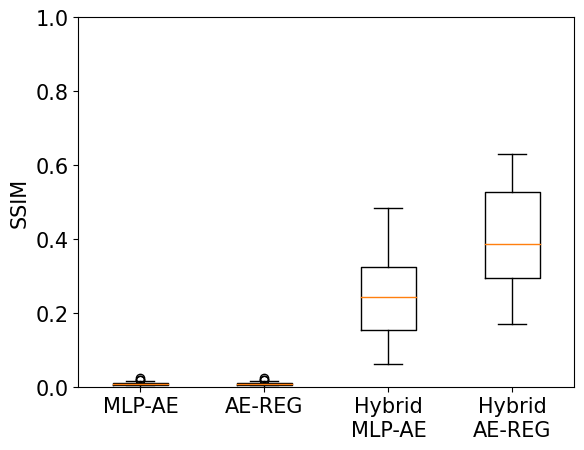

0.00954903335061982
0.009531225054259983
0.25058164094725005
0.4020114577211213


In [43]:
#Perturbation test for noise
print('SSIM of reconstruction of 10 % noised  test data')
fracs = ['MLP-AE','AE-REG', 'Hybrid\nMLP-AE', 'Hybrid\nAE-REG']
#ssims = np.load('/path/to/folder/SSIM/SSIM_data_base_test.npy')
ssims = [ssimlists_perturb1_base, ssimlists_perturb1_reg, ssimlists_perturb1_hyb_base, ssimlists_perturb1_hyb_reg]
fig1, ax1 = plt.subplots()
#ax1.set_title('SSIM of reconstruction of 10 % noised  test data')
ax1.boxplot(list(ssims))
#ax1.set_xlabel('Models', fontsize=10)
ax1.set_ylabel('SSIM', fontsize=15)
ax1.set_ylim([0,1])
plt.xticks([1, 2, 3, 4], [str(s) for s in fracs], fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('/home/ramana44/Pictures_for_report/SSIM_ReconOf10percentNoiseedTestData_LossBal'+str(alpha)+'Lat_dim'+str(latent_dim)+'TDA_'+str(frac)+'RK_deg_'+str(deg_quad)+'.png')
plt.show()


print(np.mean(ssimlists_perturb1_base))
print(np.mean(ssimlists_perturb1_reg))
print(np.mean(ssimlists_perturb1_hyb_base))
print(np.mean(ssimlists_perturb1_hyb_reg))